In [22]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [24]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [25]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [26]:
tf.keras.backend.clear_session()

In [27]:
subject = 'São_Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [28]:
data = pd.read_csv('2003_raw_São_Paulo_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,São_Paulo - PIB - Per Capita,São_Paulo - PIB - Preços de Mercado,São_Paulo - PIB - Estadual,São_Paulo - PIB - Construção Civil,São_Paulo - População,São_Paulo - INCC (%),São_Paulo - IPCA - Variação mensal durante o Plano Real (%),São_Paulo - IGP-DI,São_Paulo - Taxa Selic (%),São_Paulo - IDH - Longevidade,São_Paulo - IDH - Renda,São_Paulo - IDH - Educação,São_Paulo - NFSP - Fluxo Mensal (Milhões de reais),São_Paulo - Estoque liquido de capital fixo - (R$),São_Paulo - Desemprego,São_Paulo - Produção de Cimento (t),São_Paulo - Valor,São_Paulo - Consumo de Cimento (t)
0,2003-01-01,6.819790e+07,3.589843e+07,1.786326,5.111472e+07,38177742.0,1.70,12.53,2.70,0.082293,0.786,0.756,0.581,3.46,6.098524e+06,11.819351,NaN,0.3300,782111.0
1,2003-02-01,6.819790e+07,3.589843e+07,1.786326,5.111472e+07,38177742.0,1.51,2.25,2.17,0.088771,0.786,0.756,0.581,3.59,6.172460e+06,11.819351,NaN,0.3500,789891.0
2,2003-03-01,6.819790e+07,3.589843e+07,1.786326,5.111472e+07,38177742.0,1.39,3.86,1.59,0.090733,0.786,0.756,0.581,3.84,6.172460e+06,11.819351,39371.0,0.3500,774309.0
3,2003-04-01,6.819790e+07,3.589843e+07,1.786326,5.111472e+07,38177742.0,1.38,5.13,1.66,0.092749,0.786,0.756,0.581,3.95,6.172460e+06,11.819351,129339.0,0.3500,782071.0
4,2003-05-01,6.819790e+07,3.589843e+07,1.786326,5.111472e+07,38177742.0,0.90,6.15,0.41,0.092758,0.786,0.756,0.581,4.06,6.172460e+06,11.819351,52461.0,0.3500,841400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,9.150468e+07,1.543997e+08,2.009372,4.080742e+07,45538936.0,0.58,2.42,-0.01,0.024620,0.850,0.800,0.830,0.69,7.827728e+06,12.300000,70927.0,0.4124,978990.0
200,2019-09-01,9.150468e+07,1.543997e+08,2.009372,4.080742e+07,45538936.0,0.42,2.54,-0.51,0.022751,0.850,0.800,0.830,0.62,7.827728e+06,12.000000,NaN,0.4128,906956.0
201,2019-10-01,9.150468e+07,1.543997e+08,2.009372,4.080742e+07,45538936.0,0.46,2.49,0.50,0.022035,0.850,0.800,0.830,0.59,7.827728e+06,11.900000,113650.0,0.4146,980948.0
202,2019-11-01,9.150468e+07,1.543997e+08,2.009372,4.080742e+07,45538936.0,0.18,2.60,0.55,0.020790,0.850,0.800,0.830,0.57,7.827728e+06,11.700000,NaN,0.4144,872046.0


In [29]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      656.2690
1      745.1540
2      788.6180
3      790.1690
4      791.6631
         ...   
199         NaN
200         NaN
201         NaN
202         NaN
203         NaN
Name: São_Paulo - Consumo de Cimento (t), Length: 204, dtype: float64

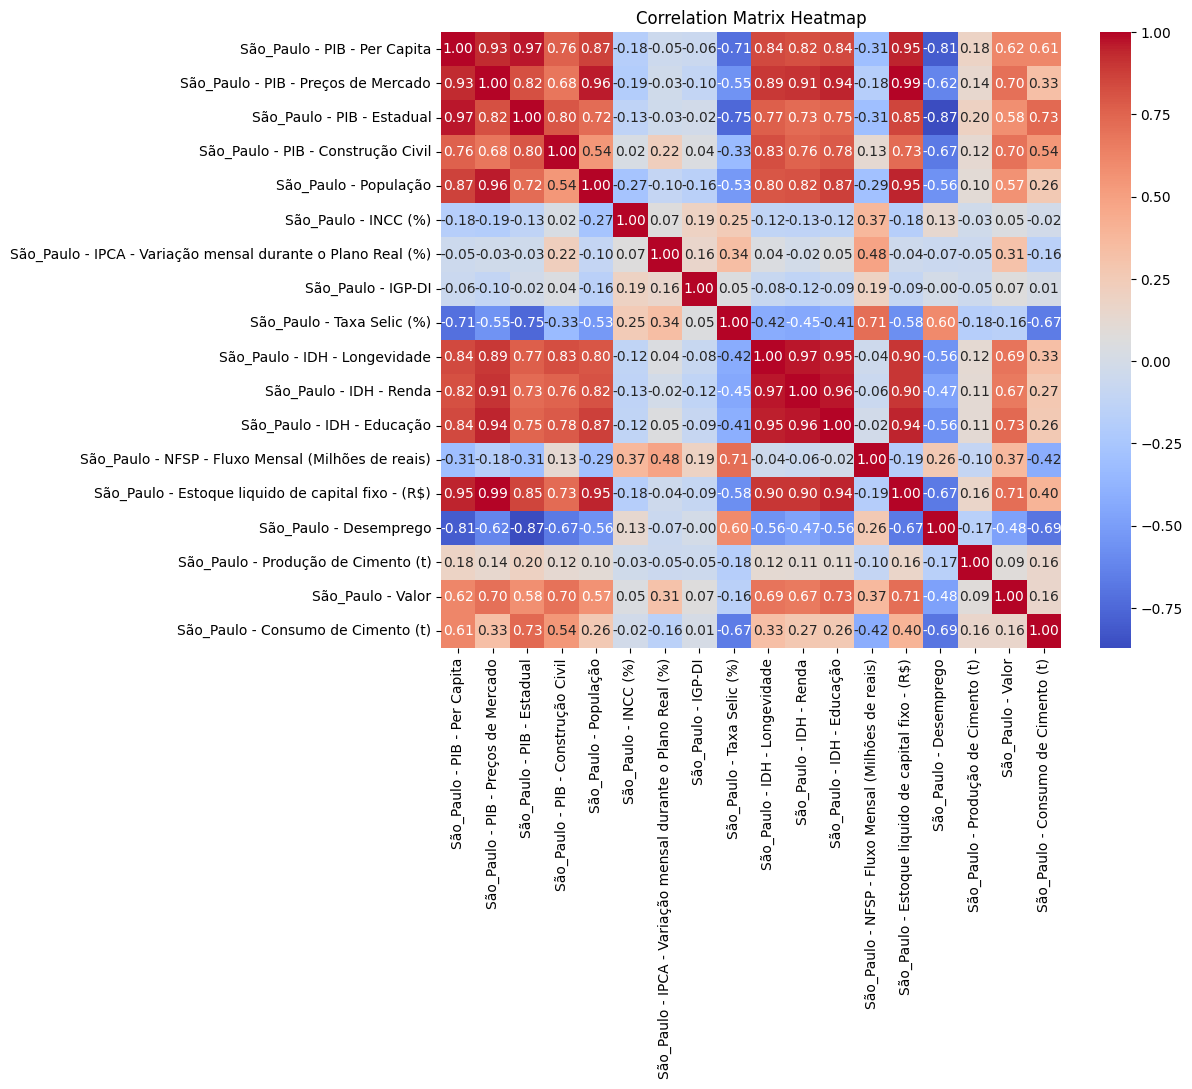

In [30]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [31]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(0.0)
input_data

,São_Paulo - PIB - Per Capita,São_Paulo - PIB - Preços de Mercado,São_Paulo - PIB - Estadual,São_Paulo - PIB - Construção Civil,São_Paulo - População,São_Paulo - INCC (%),São_Paulo - IPCA - Variação mensal durante o Plano Real (%),São_Paulo - IGP-DI,São_Paulo - Taxa Selic (%),São_Paulo - IDH - Longevidade,São_Paulo - IDH - Renda,São_Paulo - IDH - Educação,São_Paulo - NFSP - Fluxo Mensal (Milhões de reais),São_Paulo - Estoque liquido de capital fixo - (R$),São_Paulo - Desemprego,São_Paulo - Produção de Cimento (t),São_Paulo - Valor
0,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.998868,4.052332,3.466715,2.303195,-0.924268,-0.900885,-0.897615,3.108599,-1.539424,1.171268,0.000000,-0.189710
1,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.647487,-0.596188,2.630940,2.745235,-0.924268,-0.900885,-0.897615,3.275709,-1.411460,1.171268,0.000000,0.159057
2,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.425561,0.131839,1.716318,2.879123,-0.924268,-0.900885,-0.897615,3.597074,-1.411460,1.171268,-0.903911,0.159057
3,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.407068,0.706121,1.826703,3.016721,-0.924268,-0.900885,-0.897615,3.738475,-1.411460,1.171268,-0.184873,0.159057
4,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,0.519367,1.167355,-0.144465,3.017322,-0.924268,-0.900885,-0.897615,3.879875,-1.411460,1.171268,-0.799294,0.159057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.804967,1.699468,0.239584,-0.126784,1.694116,-0.590259,-0.966985,-1.264088,-0.729479,1.305122,1.994817,1.556456,-0.374997,1.441346,1.213289,-0.316536,0.633382
176,0.804967,1.699468,0.239584,-0.126784,1.694116,-0.479297,-0.881068,-0.412544,-0.941281,1.305122,1.994817,1.556456,-0.439270,1.441346,1.213289,-1.100534,0.528751
177,0.804967,1.699468,0.239584,-0.126784,1.694116,-1.034110,-0.808718,0.186692,-1.140710,1.305122,1.994817,1.556456,-0.503543,1.441346,1.213289,-0.351573,0.483411
178,0.804967,1.699468,0.239584,-0.126784,1.694116,-0.571766,-0.614276,-0.633314,-1.226481,1.305122,1.994817,1.556456,-0.503543,1.441346,1.265392,0.000000,0.567116


In [32]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,São_Paulo - PIB - Per Capita,São_Paulo - PIB - Preços de Mercado,São_Paulo - PIB - Estadual,São_Paulo - PIB - Construção Civil,São_Paulo - População,São_Paulo - INCC (%),São_Paulo - IPCA - Variação mensal durante o Plano Real (%),São_Paulo - IGP-DI,São_Paulo - Taxa Selic (%),São_Paulo - IDH - Longevidade,São_Paulo - IDH - Renda,São_Paulo - IDH - Educação,São_Paulo - NFSP - Fluxo Mensal (Milhões de reais),São_Paulo - Estoque liquido de capital fixo - (R$),São_Paulo - Desemprego,São_Paulo - Produção de Cimento (t),São_Paulo - Valor
0,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.998868,4.052332,3.466715,2.303195,-0.924268,-0.900885,-0.897615,3.108599,-1.539424,1.171268,0.000000,-0.189710
1,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.647487,-0.596188,2.630940,2.745235,-0.924268,-0.900885,-0.897615,3.275709,-1.411460,1.171268,0.000000,0.159057
2,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.425561,0.131839,1.716318,2.879123,-0.924268,-0.900885,-0.897615,3.597074,-1.411460,1.171268,-0.903911,0.159057
3,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,1.407068,0.706121,1.826703,3.016721,-0.924268,-0.900885,-0.897615,3.738475,-1.411460,1.171268,-0.184873,0.159057
4,-1.617749,-1.393947,-1.396286,0.164474,-1.699219,0.519367,1.167355,-0.144465,3.017322,-0.924268,-0.900885,-0.897615,3.879875,-1.411460,1.171268,-0.799294,0.159057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.985646,1.462172,0.595948,0.635141,1.511738,-0.238878,0.629248,-1.406012,0.272188,1.305122,0.868711,1.272201,0.794771,1.416222,-0.349808,0.000000,1.278602
164,0.985646,1.462172,0.595948,0.635141,1.511738,-0.608753,0.837256,-0.112926,0.272188,1.305122,0.868711,1.272201,0.730498,1.416222,-0.297705,0.000000,1.180947
165,0.985646,1.462172,0.595948,0.635141,1.511738,-0.534778,0.877953,-0.743700,0.272188,1.305122,0.868711,1.272201,0.743353,1.416222,-0.245602,0.000000,1.194898
166,0.985646,1.462172,0.595948,0.635141,1.511738,-0.756703,1.000045,-0.586006,0.248413,1.305122,0.868711,1.272201,0.614807,1.416222,-0.245602,0.000000,1.160021


In [33]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      656.2690
1      745.1540
2      788.6180
3      790.1690
4      791.6631
         ...   
163    913.3290
164    849.2620
165    897.8830
166    860.0590
167    771.4170
Name: São_Paulo - Consumo de Cimento (t), Length: 168, dtype: float64

In [34]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [35]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [36]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,São_Paulo - PIB - Per Capita,São_Paulo - PIB - Preços de Mercado,São_Paulo - PIB - Estadual,São_Paulo - PIB - Construção Civil,São_Paulo - População,São_Paulo - INCC (%),São_Paulo - IPCA - Variação mensal durante o Plano Real (%),São_Paulo - IGP-DI,São_Paulo - Taxa Selic (%),São_Paulo - IDH - Longevidade,São_Paulo - IDH - Renda,São_Paulo - IDH - Educação,São_Paulo - NFSP - Fluxo Mensal (Milhões de reais),São_Paulo - Estoque liquido de capital fixo - (R$),São_Paulo - Desemprego,São_Paulo - Produção de Cimento (t),São_Paulo - Valor
132,1.109738,0.968531,0.999411,1.427272,1.133360,-0.960135,1.058830,0.297077,-0.755853,0.956780,0.868711,1.177449,-0.285015,0.834026,-1.183460,-0.836202,0.682209
133,1.109738,0.968531,0.999411,1.427272,1.133360,0.482379,-1.364912,-0.160234,-0.688658,0.956780,0.868711,1.177449,-0.349288,1.129318,-0.922944,0.000000,0.734524
134,1.109738,0.968531,0.999411,1.427272,1.133360,-0.534778,-1.052901,0.549386,-0.626634,0.956780,0.868711,1.177449,-0.374997,1.129318,-0.766634,0.000000,0.741500
135,1.109738,0.968531,0.999411,1.427272,1.133360,-0.627247,-0.627842,1.542855,-0.571481,0.956780,0.868711,1.177449,-0.259306,1.129318,-0.870841,0.000000,0.751963
136,1.109738,0.968531,0.999411,1.427272,1.133360,0.482379,-0.320352,-0.081387,-0.516512,0.956780,0.868711,1.177449,-0.053632,1.129318,-0.975047,0.000000,0.769401
137,1.109738,0.968531,0.999411,1.427272,1.133360,2.646150,-0.107822,-1.500628,-0.510405,0.956780,0.868711,1.177449,0.023495,1.129318,-1.079253,-0.590411,1.051903
138,1.109738,0.968531,0.999411,1.427272,1.133360,0.075516,0.082098,-1.784477,-0.510405,0.956780,0.868711,1.177449,-0.002214,1.129318,-1.131357,0.000000,1.104218
139,1.109738,0.968531,0.999411,1.427272,1.133360,0.241960,0.086620,-1.658322,-0.510405,0.956780,0.868711,1.177449,-0.143614,1.129318,-1.235563,0.000000,1.177459
140,1.109738,0.968531,0.999411,1.427272,1.133360,-0.997122,0.204189,-0.696392,-0.510054,0.956780,0.868711,1.177449,-0.182178,1.129318,-1.339770,0.000000,1.187922
141,1.109738,0.968531,0.999411,1.427272,1.133360,-0.867666,0.470982,-0.759469,-0.510405,0.956780,0.868711,1.177449,-0.105051,1.129318,-1.443976,0.050456,1.219311


In [37]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [38]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [39]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [40]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [41]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [42]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2619782521, 1741528078, 3010445962, 1072532236, 1176191839, 3616190010, 1397381804, 677192341, 1370093214, 2592547213]


Step: 0 ___________________________________________
val_loss: 1313449728.0
winner_seed: 2619782521


Step: 1 ___________________________________________
val_loss: 9117.7568359375
winner_seed: 1741528078


Step: 2 ___________________________________________
val_loss: 9151.234375


Step: 3 ___________________________________________
val_loss: 1.9060512956350464e+16


Step: 4 ___________________________________________
val_loss: 1.6290465208860672e+16


Step: 5 ___________________________________________
val_loss: 790906011648.0


Step: 6 ___________________________________________
val_loss: 34063.171875


Step: 7 ___________________________________________
val_loss: 41173.80859375


Step: 8 ___________________________________________
val_loss: 3079957823619072.0


Step: 9 ___________________________________________
val_loss: 29502445568.0
1/1 [========================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,863.233521,863.143494,863.189331,863.177734,863.201538,863.344238,863.225769,863.193481,863.266785,863.268188,863.239929,863.245728
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,3.001526,89.536499,73.043335,23.751282,78.398438,46.043213,94.063232,115.796509,43.689209,117.67981,8.806091,171.013733


[3424096942, 3690809070, 2107004282, 751810419, 2709479854, 4144935054, 1509610541, 3624289434, 83565251, 2726655699]


Step: 0 ___________________________________________
val_loss: 4005227008.0
winner_seed: 3424096942


Step: 1 ___________________________________________
val_loss: 32981.625
winner_seed: 3690809070


Step: 2 ___________________________________________
val_loss: 38820.97265625


Step: 3 ___________________________________________
val_loss: 234240507904.0


Step: 4 ___________________________________________
val_loss: 548348032.0


Step: 5 ___________________________________________
val_loss: 16352488448.0


Step: 6 ___________________________________________
val_loss: 16303.3876953125
winner_seed: 1509610541


Step: 7 ___________________________________________
val_loss: 43675.48828125


Step: 8 ___________________________________________
val_loss: 1.7122099726385152e+16


Step: 9 ___________________________________________
val_loss: 129424192.0
1/1 [===================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,884.839355,884.658691,884.322266,884.328369,904.533813,884.634033,884.176758,882.908081,884.408813,884.616821,885.291748,884.993652
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,24.607361,111.051697,94.17627,2.600647,37.066162,67.333008,73.112244,96.081909,22.54718,96.331177,13.245728,192.761658


[3773672858, 2018198548, 712020773, 3601412010, 2744965459, 1793670865, 3186415216, 3110470196, 2127325485, 2870819268]


Step: 0 ___________________________________________
val_loss: 1.7421571526599115e+19
winner_seed: 3773672858


Step: 1 ___________________________________________
val_loss: 36739.96484375
winner_seed: 2018198548


Step: 2 ___________________________________________
val_loss: 8078509568.0


Step: 3 ___________________________________________
val_loss: 64551.36328125


Step: 4 ___________________________________________
val_loss: 4877810688.0


Step: 5 ___________________________________________
val_loss: 45377.6171875


Step: 6 ___________________________________________
val_loss: 161730.109375


Step: 7 ___________________________________________
val_loss: 45504.25


Step: 8 ___________________________________________
val_loss: 34603.59765625
winner_seed: 2127325485


Step: 9 ___________________________________________
val_loss: 2344499968.0
1/1 [===================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669,1015.060669
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,154.828674,241.453674,224.914673,128.131653,73.460693,197.759644,57.771667,36.070679,108.104675,34.112671,143.014648,322.828674


[3235689979, 274427159, 256102395, 453421371, 583404883, 2762036123, 225075, 4014987412, 1337989527, 1858338279]


Step: 0 ___________________________________________
val_loss: 6737863680.0
winner_seed: 3235689979


Step: 1 ___________________________________________
val_loss: 43911.05859375
winner_seed: 274427159


Step: 2 ___________________________________________
val_loss: 36288.765625
winner_seed: 256102395


Step: 3 ___________________________________________
val_loss: 3414404864.0


Step: 4 ___________________________________________
val_loss: 25184.458984375
winner_seed: 583404883


Step: 5 ___________________________________________
val_loss: 17468796.0


Step: 6 ___________________________________________
val_loss: 3.78233148372849e+22


Step: 7 ___________________________________________
val_loss: 4.909999774000797e+23


Step: 8 ___________________________________________
val_loss: 43978.45703125


Step: 9 ___________________________________________
val_loss: 24065.9921875
w

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873,976.19873
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,115.966736,202.591736,186.052734,89.269714,34.598755,158.897705,18.909729,2.79126,69.242737,4.749268,104.15271,283.966736


[3132951224, 449543332, 2763086252, 1532741016, 4063828199, 1140557499, 1944917566, 3476745323, 295909558, 990317389]


Step: 0 ___________________________________________
val_loss: 1.1647402624679936e+16
winner_seed: 3132951224


Step: 1 ___________________________________________
val_loss: 332045975552.0
winner_seed: 449543332


Step: 2 ___________________________________________
val_loss: 29308.08203125
winner_seed: 2763086252


Step: 3 ___________________________________________
val_loss: 47897.92578125


Step: 4 ___________________________________________
val_loss: 5.732600052354908e+17


Step: 5 ___________________________________________
val_loss: 13708.203125
winner_seed: 1140557499


Step: 6 ___________________________________________
val_loss: 47458.6328125


Step: 7 ___________________________________________
val_loss: 31830.484375


Step: 8 ___________________________________________
val_loss: 47065.921875


Step: 9 ___________________________________________
val_loss: 3593

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981,924.742981
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,64.510986,151.135986,134.596985,37.813965,16.856995,107.441956,32.546021,54.247009,17.786987,56.205017,52.69696,232.510986


[2676157093, 80629503, 1692475279, 3061539913, 1729388722, 2511441781, 2734146969, 1457795936, 3292903606, 655933008]


Step: 0 ___________________________________________
val_loss: 1.3715985695884255e+21
winner_seed: 2676157093


Step: 1 ___________________________________________
val_loss: 139891916800.0
winner_seed: 80629503


Step: 2 ___________________________________________
val_loss: 43169.20703125
winner_seed: 1692475279


Step: 3 ___________________________________________
val_loss: 565971124224.0


Step: 4 ___________________________________________
val_loss: 339647488.0


Step: 5 ___________________________________________
val_loss: 7851.9443359375
winner_seed: 2511441781


Step: 6 ___________________________________________
val_loss: 2968193.75


Step: 7 ___________________________________________
val_loss: 194255584.0


Step: 8 ___________________________________________
val_loss: 1342888214528.0


Step: 9 ___________________________________________
val_loss: 42302.0820312

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353,853.274353
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,6.957642,79.667358,63.128357,33.654663,88.325623,35.973328,104.014648,125.715637,53.681641,127.673645,18.771667,161.042358


[416741693, 1381952897, 3508346233, 1733705731, 314669251, 589885287, 2427021720, 1078572432, 1629381836, 556206631]


Step: 0 ___________________________________________
val_loss: 61371168.0
winner_seed: 416741693


Step: 1 ___________________________________________
val_loss: 10396.8251953125
winner_seed: 1381952897


Step: 2 ___________________________________________
val_loss: 7743.27587890625
winner_seed: 3508346233


Step: 3 ___________________________________________
val_loss: 41326.84375


Step: 4 ___________________________________________
val_loss: 124291.390625


Step: 5 ___________________________________________
val_loss: 49716.95703125


Step: 6 ___________________________________________
val_loss: 7751.70947265625


Step: 7 ___________________________________________
val_loss: 8581.5595703125


Step: 8 ___________________________________________
val_loss: 36819.01953125


Step: 9 ___________________________________________
val_loss: 6308.400390625
winner_seed: 556206631


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,841.404785,842.979248,914.142517,930.482788,841.782043,837.86322,843.638,843.628967,843.709534,843.698303,843.917419,846.563232
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,18.827209,69.372253,123.996521,43.553772,99.817932,20.562195,113.651001,135.361023,63.24646,137.249695,28.128601,154.331238


[868662639, 83693818, 1529790004, 3521575673, 3514001452, 2044117768, 2948017843, 2271491973, 2399417850, 2704284204]


Step: 0 ___________________________________________
val_loss: 8337.462890625
winner_seed: 868662639


Step: 1 ___________________________________________
val_loss: 41278.3671875


Step: 2 ___________________________________________
val_loss: 48923.171875


Step: 3 ___________________________________________
val_loss: 11662.02734375


Step: 4 ___________________________________________
val_loss: 8150.06103515625
winner_seed: 3514001452


Step: 5 ___________________________________________
val_loss: 44678.21875


Step: 6 ___________________________________________
val_loss: 3290973863936.0


Step: 7 ___________________________________________
val_loss: 2463730237440.0


Step: 8 ___________________________________________
val_loss: 19029.861328125


Step: 9 ___________________________________________
val_loss: 7979.84130859375
winner_seed: 2704284204
1/1 [===============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283,867.277283
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,7.045288,93.670288,77.131287,19.651733,74.322693,49.976257,90.011719,111.712708,39.678711,113.670715,4.768738,175.045288


[1120332073, 1256741057, 4062934842, 3380345510, 2274417206, 3255233087, 55294024, 4095984702, 3166530042, 843120080]


Step: 0 ___________________________________________
val_loss: 399669216.0
winner_seed: 1120332073


Step: 1 ___________________________________________
val_loss: 150787440.0
winner_seed: 1256741057


Step: 2 ___________________________________________
val_loss: 50713.7890625
winner_seed: 4062934842


Step: 3 ___________________________________________
val_loss: 91361896.0


Step: 4 ___________________________________________
val_loss: 7.766686255818998e+20


Step: 5 ___________________________________________
val_loss: 6.2230422991656714e+19


Step: 6 ___________________________________________
val_loss: 9.065838958629356e+17


Step: 7 ___________________________________________
val_loss: 8849.1884765625
winner_seed: 4095984702


Step: 8 ___________________________________________
val_loss: 46555.8046875


Step: 9 ___________________________________________
val_loss: 

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,871.234192,884.73584,863.405701,848.47406,838.080627,846.152222,820.890503,831.232056,862.530579,861.972168,843.60614,874.981934
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,11.002197,111.128845,73.259705,38.454956,103.519348,28.851196,136.398499,147.757935,44.425415,118.97583,28.43988,182.749939


[2669104043, 1807707716, 3459460175, 2220283539, 3092632279, 3773768479, 548016921, 2978573826, 267129092, 2656078504]


Step: 0 ___________________________________________
val_loss: 48490.109375
winner_seed: 2669104043


Step: 1 ___________________________________________
val_loss: 37989285888.0


Step: 2 ___________________________________________
val_loss: 1402253952.0


Step: 3 ___________________________________________
val_loss: 45660.87890625
winner_seed: 2220283539


Step: 4 ___________________________________________
val_loss: 47995.6953125


Step: 5 ___________________________________________
val_loss: 189075.953125


Step: 6 ___________________________________________
val_loss: 1180688056320.0


Step: 7 ___________________________________________
val_loss: 44280.94140625
winner_seed: 2978573826


Step: 8 ___________________________________________
val_loss: 52170.5390625


Step: 9 ___________________________________________
val_loss: 1.1548153446662144e+16
1/1 [=============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109,1041.912109
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,181.680115,268.305115,251.766113,154.983093,100.312134,224.611084,84.623108,62.922119,134.956116,60.964111,169.866089,349.680115


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,913.917786,915.398438,920.352661,920.492981,912.606445,911.046082,909.039856,909.942871,913.238281,913.202148,911.452148,914.825012
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,53.685786,141.791438,130.206661,33.563981,28.993555,93.745082,48.249144,69.047129,6.282281,67.745852,39.406148,222.593012


In [43]:
display(mae)
display(mape)

913.7929

0.09645699935652102